In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import StandardScaler

In [2]:
ff_data_list = []

for year in range(2002, 2019):
    ff_data = pd.read_csv('FF offense '+str(year)+'.csv')
    ff_data['YEAR'] = year
    ff_data = ff_data[:150]
    
    # Remove injury designation from NAME column.
    for N in ff_data.NAME:
        if N[-2:] == ' P' or N[-2:] == ' O' or N[-2:] == ' Q' or N[-2:] == ' D':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-2])
        if N[-3:] == ' IR':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-3])
        if N[-4:] == ' SUS':
            ff_data.NAME = ff_data.NAME.replace(N, N[:-4])
            
    # Correct innaccurate position labels in POS column    
    no_qb = ff_data[ff_data.POS != 'QB']
    no_qb = no_qb[no_qb['PASS YDS'] > 106]
    index_ = no_qb.index.values
    
    for p in no_qb.POS:
        no_qb.POS = no_qb.POS.replace(p, 'QB')
        
    for i in index_:
        ff_data.loc[i] = no_qb.loc[i]
         
    ff_data_list.append(ff_data)

ff_data_list.reverse()
ALL = pd.concat(ff_data_list)
ALL = ALL.reset_index(drop=True)
ALL = ALL[ALL.POS != 'FB']
positions = list(ALL['POS'])
# ALL = ALL[['YEAR', 'RANK', 'NAME', 'TEAM', 'POS', 'PTS']]
stat_matrix = ALL.drop(columns=['POS', 'TEAM', 'PTS', 'RANK', 'GMS', 'YEAR'])
stat_matrix = stat_matrix.set_index('NAME')

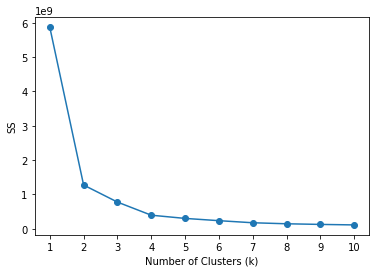

In [48]:
k_range = range(1,11)
SS = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(stat_matrix)
    SS.append(KM.inertia_)
    
plt.plot(k_range, SS, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [8]:
best=0

for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(stat_matrix)
    silhouette_avg = silhouette_score(stat_matrix, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.7459918592872101
For n_clusters = 3 The average silhouette_score is : 0.6249124774846647
For n_clusters = 4 The average silhouette_score is : 0.6288375516360286
For n_clusters = 5 The average silhouette_score is : 0.620887454495733
For n_clusters = 6 The average silhouette_score is : 0.568544200289893
For n_clusters = 7 The average silhouette_score is : 0.5316708956850712
For n_clusters = 8 The average silhouette_score is : 0.5212950705770156
For n_clusters = 9 The average silhouette_score is : 0.5181887518661138
For n_clusters = 10 The average silhouette_score is : 0.4943493225214256
Optimal KMeans n_clusters parameter: 2


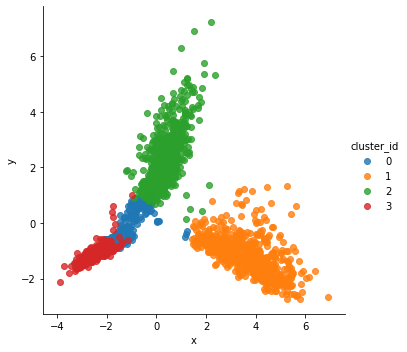

In [163]:
cluster_df = stat_matrix.copy()

scaled_cluster = StandardScaler().fit_transform(cluster_df)
# scaled_cluster_df = pd.DataFrame(scaled_cluster)
pca = PCA()
XY = pca.fit_transform(scaled_cluster)
# pca.explained_variance_ratio_.cumsum()


KM = KMeans(n_clusters=4)
labels = KM.fit_predict(scaled_cluster)

cluster_df['cluster_id'] = labels
cluster_df['POS'] = positions
cluster_df['x'] = XY[:,0]
cluster_df['y'] = XY[:,1]

sns.lmplot(data=cluster_df, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, legend_out=True)
plt.show()

In [159]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pca.n_components_)

[0.51692578 0.23796952 0.1177107  0.06206225 0.02313746 0.01777268
 0.01274165 0.00666188 0.00319294 0.00182514]
1.0
10


Keep playing wit n_compnents and see if it makes a dfference

In [176]:
cluster_df[cluster_df.cluster_id == 0].sort_values('PASS YDS', ascending=False)

,PASS YDS,PASS TDS,INT,RUSH YDS,RUSH TDS,REC,REC YDS,REC TDS,FUM LST,PTS / GM,cluster_id,POS,x,y
NAME,,,,,,,,,,,,,,
Vinny Testaverde,1385,7,2,17,0,0,0,0,0,11.6,0,QB,1.200812,-0.410896
Charlie Whitehurst,1326,7,2,90,0,0,10,0,0,12.4,0,QB,1.244725,-0.286950
Rich Gannon,1274,6,4,18,0,0,0,0,0,9.8,0,QB,1.147894,-0.487688
Mohamed Sanu,79,1,0,51,0,56,790,5,0,7.7,0,WR,-1.658315,-0.673108
Rod Smith,72,0,0,98,0,74,845,3,0,7.7,0,WR,-1.770460,-0.502610
Isaac Bruce,66,0,0,17,0,69,981,5,0,8.8,0,WR,-1.965830,-0.778334
Jarvis Landry,63,0,0,60,1,81,976,4,1,8.5,0,WR,-1.809149,-0.513245
Mohamed Sanu,51,1,0,10,0,67,703,5,0,7.2,0,WR,-1.766601,-0.720504
Willie Snead,50,1,0,0,0,72,895,4,0,8.0,0,WR,-1.851755,-0.745088


In [129]:
WR_TE = ALL.copy()
WR_TE = WR_TE[WR_TE.POS != 'QB']
WR_TE = WR_TE[WR_TE.POS != 'RB']
WR_TE_positions = list(WR_TE['POS'])
WR_TE = WR_TE.drop(columns=['POS', 'TEAM', 'PTS', 'RANK', 'GMS', 'YEAR'])
WR_TE = WR_TE.set_index('NAME')
WR_TE.head()

,PASS YDS,PASS TDS,INT,RUSH YDS,RUSH TDS,REC,REC YDS,REC TDS,FUM LST,PTS / GM
NAME,,,,,,,,,,
Tyreek Hill,0,0,0,151,1,87,1479,12,0,15.1
Antonio Brown,0,0,0,0,0,104,1297,15,0,14.6
Davante Adams,0,0,0,0,0,111,1386,13,0,14.6
DeAndre Hopkins,0,0,0,-7,0,115,1572,11,2,13.7
Julio Jones,0,0,0,12,0,113,1677,8,2,13.3


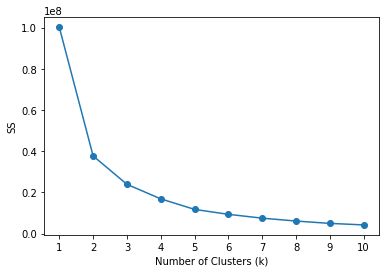

In [124]:
k_range = range(1,11)
SS = []

for k in k_range:
    KM = KMeans(n_clusters=k)
    KM.fit(WR_TE)
    SS.append(KM.inertia_)
    
plt.plot(k_range, SS, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('SS')
plt.xticks(k_range)
plt.show()

In [120]:
for n_clusters in range(2,11):
    KM = KMeans(n_clusters=n_clusters)
    KM_labels = KM.fit_predict(WR_TE)
    silhouette_avg = silhouette_score(WR_TE, KM_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    if silhouette_avg > best:
        best = silhouette_avg
        best_n_clusters = n_clusters
        
print('Optimal KMeans n_clusters parameter:', best_n_clusters)

For n_clusters = 2 The average silhouette_score is : 0.5810498436386902
For n_clusters = 3 The average silhouette_score is : 0.49035146658975576
For n_clusters = 4 The average silhouette_score is : 0.49170528815939807
For n_clusters = 5 The average silhouette_score is : 0.5015807100696258
For n_clusters = 6 The average silhouette_score is : 0.46078994125366307
For n_clusters = 7 The average silhouette_score is : 0.46667051922762226
For n_clusters = 8 The average silhouette_score is : 0.467965148458464
For n_clusters = 9 The average silhouette_score is : 0.46045278404425755
For n_clusters = 10 The average silhouette_score is : 0.44949535112237
Optimal KMeans n_clusters parameter: 2


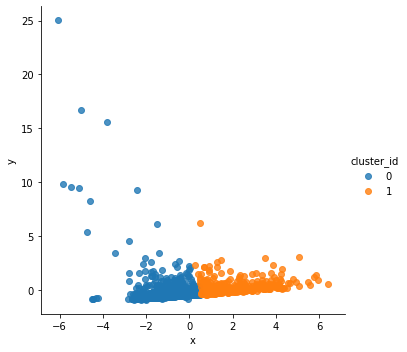

In [164]:
WR_TE1 = WR_TE.copy()

scaled_WR_TE = StandardScaler().fit_transform(WR_TE1)
# pca = PCA(n_components=3)
pca = PCA()
XY = pca.fit_transform(scaled_WR_TE)

KM = KMeans(n_clusters=2)
labels = KM.fit_predict(scaled_WR_TE)

WR_TE1['cluster_id'] = labels
WR_TE1['POS'] = WR_TE_positions
WR_TE1['x'] = XY[:,0]
WR_TE1['y'] = XY[:,1]

sns.lmplot(data=WR_TE1, x='x', y='y', hue='cluster_id', fit_reg=False, legend=True, legend_out=True)
plt.show()

In [165]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())
print(pca.n_components_)

[0.30848547 0.18077405 0.16153948 0.10262377 0.09644209 0.06484382
 0.03821389 0.02220712 0.01791165 0.00695867]
1.0
10


WR_TE dataframe; Results from n_clusters = 2 <br>
0 = mean receiving yards > 700 <br>
1 = mean receiving yards < 700

In [171]:
print(WR_TE1[WR_TE1.cluster_id == 0]['REC YDS'].max())
print(WR_TE1[WR_TE1.cluster_id == 1]['REC YDS'].max())

1130
1964
